## 比赛结果预测竞赛：Google Cloud & NCAA® ML Competition 2020-NCAAM

#### 竞赛说明
* 网站：https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament
* 2020年竞赛因新冠肺炎疫情取消

#### 建模方法
* 特征变量
    * NCAA决赛前各支参赛球队在四个排行榜（WOL, WLK, SAG, GRN）上的平均排名
    * 各支参赛球队常规赛的平均比赛数据
* 预测模型
    * XGBoost回归器+逻辑回归分类器

#### 模型评估
* 总体评估
    * 对数损失：0.5323
    * 准确率：70.7%
* 按年评估
    * 2016：对数损失：0.5595，准确率：70.9%
    * 2017：对数损失：0.4965，准确率：73.1%
    * 2018：对数损失：0.6027，准确率：68.7%
    * 2019：对数损失：0.4704，准确率：70.1%

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold

sns.set_style('white')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']}) #图中显示中文

#### 1. 数据预处理

导入数据

In [2]:
# 从网站下载并解压数据到以下目录
data_folder = os.path.join(os.path.pardir, 'projects', 'ncaa_ml_competition', 'NCAAM_2020', 'google-cloud-ncaa-march-madness-2020-division-1-mens-tournament')

year = 2020
gender = 'M'
stage = 1
sub_folder = '{}DataFiles_Stage{}'.format(gender, stage)
tourney_results = pd.read_csv(os.path.join(data_folder, sub_folder, '{}NCAATourneyDetailedResults.csv'.format(gender)))
regular_results = pd.read_csv(os.path.join(data_folder, sub_folder, '{}RegularSeasonDetailedResults.csv'.format(gender)))
rank = pd.read_csv(os.path.join(data_folder, sub_folder, '{}MasseyOrdinals.csv'.format(gender)))

重新整理数据

In [3]:
def prepare_data(df):

    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT',
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc']=='H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc']=='A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    

    df.columns = [x.replace('W', 'T1_').replace('L', 'T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L', 'T1_').replace('W', 'T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N', 'location'] = 0
    output.loc[output.location=='H', 'location'] = 1
    output.loc[output.location=='A', 'location'] = -1
    output.location = output.location.astype(int)

    output['PointDiff'] = output['T1_Score'] - output['T2_Score']

    return output

In [4]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

添加常规赛平均比赛数据

In [5]:
boxscore_cols = ['T1_Score', 'T2_Score',
                 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast',
                 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF',
                 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast',
                 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
                 'PointDiff']

boxscore_cols = ['T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
                 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',
                 'PointDiff']

funcs = [np.mean]

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how='left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how='left')

添加平均排名

In [6]:
mask = (rank.RankingDayNum<136)&(rank.SystemName.isin(['WOL', 'WLK', 'SAG', 'GRN']))
rank_sel = rank[mask]
rank_sel = rank_sel.sort_values(['Season', 'SystemName', 'RankingDayNum'], ascending=False)
rank_sel = rank_sel.drop_duplicates(subset=['Season', 'SystemName', 'TeamID'], keep='first')
rank_sel_gpy = rank_sel.groupby(['Season','TeamID'], as_index=False).mean()

rank_T1 = rank_sel_gpy[['Season', 'TeamID', 'OrdinalRank']].copy()
rank_T2 = rank_sel_gpy[['Season', 'TeamID', 'OrdinalRank']].copy()
rank_T1.rename(columns={'TeamID': 'T1_TeamID', 'OrdinalRank': 'T1_Rank'}, inplace=True)
rank_T2.rename(columns={'TeamID': 'T2_TeamID', 'OrdinalRank': 'T2_Rank'}, inplace=True)
tourney_data = pd.merge(tourney_data, rank_T1, on = ['Season', 'T1_TeamID'], how='left')
tourney_data = pd.merge(tourney_data, rank_T2, on = ['Season', 'T2_TeamID'], how='left')

准备建模数据

In [7]:
X = tourney_data[tourney_data.columns[6:]].values
y = (tourney_data['T1_Score'] - tourney_data['T2_Score']).values
r = np.where(y>0, 0, 1)

# train test split
mask = tourney_data.Season <= 2015
Xtrain = X[mask]
Xtest = X[~mask]
ytrain = y[mask]
ytest = y[~mask]
rtrain = r[mask]
rtest = r[~mask]

#### 2. XGBoost回归器+逻辑回归分类器

使用交叉验证确定超参数

In [8]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'mae'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.02
param_reg['subsample'] = 0.2
param_reg['colsample_bytree'] = 1.0
param_reg['max_depth'] = 1
param_reg['num_parallel_tree'] = 1
param_reg['min_child_weight'] = 45

parameter_dic = {'eta':np.arange(0.02, 0.1, 0.01)}
param_tune = list(parameter_dic.keys())[0]
param_len = len(parameter_dic[param_tune])

cross_validation_fold = 10

xgb_cv = []
kf = KFold(n_splits=cross_validation_fold, shuffle=True, random_state=42)

train_mean = []
val_mean = []

reg_progress = {}
clf_progress = {}

reg_num_boost_round_mean = []
clf_num_boost_round_mean = []

for i in range(param_len):
    param_reg[param_tune] = parameter_dic[param_tune][i]
    
    train_scores = []
    val_scores = []
    
    reg_num_boost_round = []
    clf_num_boost_round = []
    
    for train, val in kf.split(Xtrain, ytrain):
        dtrain = xgb.DMatrix(Xtrain[train], label = ytrain[train])
        dval = xgb.DMatrix(Xtrain[val], label = ytrain[val])
        reg = xgb.train(params=param_reg, dtrain=dtrain,
                        num_boost_round=3000,
                        early_stopping_rounds=25, evals=[(dval,'validation')],
                        evals_result=reg_progress,
                        verbose_eval=False)
        reg_num_boost_round.append(len(reg_progress['validation']['mae']))
        Ztrain = reg.predict(dtrain).reshape(-1, 1)
        Zval = reg.predict(dval).reshape(-1, 1)
        ltrain = xgb.DMatrix(Ztrain, label=rtrain[train])
        lval = xgb.DMatrix(Zval, label = rtrain[val])
        
        clf = LogisticRegression(solver='liblinear', C=10000) # minimizing regularization by setting C to a very large number
        clf.fit(Ztrain, rtrain[train])
        train_scores.append(log_loss(rtrain[train], clf.predict_proba(Ztrain)))
        val_scores.append(log_loss(rtrain[val], clf.predict_proba(Zval)))

    train_mean.append(np.mean(np.array(train_scores)))
    val_mean.append(np.mean(np.array(val_scores)))
    
    reg_num_boost_round_mean.append(np.mean(np.array(reg_num_boost_round)))

最优的eta为：0.02
对数损失(cv)：0.5424


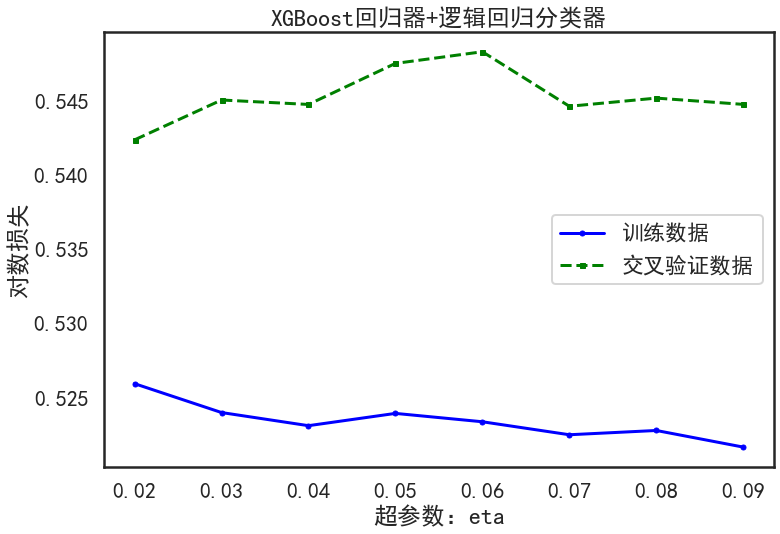

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(parameter_dic[param_tune], np.array(train_mean),
         color='blue', marker='o', markersize=5, label='训练数据')
plt.plot(parameter_dic[param_tune], np.array(val_mean),
         color='green', linestyle='--', marker='s', markersize=5, label='交叉验证数据')
plt.xlabel('超参数：{}'.format(param_tune))
plt.ylabel('对数损失')
plt.legend()
plt.title('XGBoost回归器+逻辑回归分类器')
print('最优的{}为：{}'.format(param_tune, parameter_dic[param_tune][np.argmin(val_mean)]))
print('对数损失(cv)：{:.4f}'.format(np.min(val_mean)))

模型评估

In [10]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'mae'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.02
param_reg['subsample'] = 0.2
param_reg['colsample_bytree'] = 1.0
param_reg['max_depth'] = 1
param_reg['num_parallel_tree'] = 1
param_reg['min_child_weight'] = 45

dtrain = xgb.DMatrix(Xtrain, label = ytrain)
reg = xgb.train(params=param_reg, dtrain=dtrain,
                num_boost_round=int(reg_num_boost_round_mean[np.argmin(val_mean)]),
                verbose_eval=False)
        
Ztrain = reg.predict(dtrain).reshape(-1, 1)
clf = LogisticRegression(solver='liblinear', C=10000)
clf.fit(Ztrain, rtrain)

dtest = xgb.DMatrix(Xtest, label = ytest)
Ztest = reg.predict(dtest).reshape(-1,1)
ytest_prob = clf.predict_proba(Ztest)

print('对数损失：{:.4f}'.format(log_loss(rtest, ytest_prob)))
print('准确率：{:.1f}%'.format(accuracy_score(rtest, np.argmax(ytest_prob, axis=1))*100))

对数损失：0.5320
准确率：70.9%


按年评估

In [11]:
for season in range(2016, 2020):
    mask = tourney_data.Season == season
    rmask = np.where(y[mask]>0, 0, 1)
    dmask = xgb.DMatrix(X[mask], label = y[mask])
    Zmask = reg.predict(dmask).reshape(-1,1)
    ymask_prob = clf.predict_proba(Zmask)
    print('{}：对数损失：{:.4f}，准确率：{:.1f}%'.format(season, log_loss(rmask, ymask_prob), accuracy_score(rmask, np.argmax(ymask_prob, axis=1))*100))

2016：对数损失：0.5589，准确率：70.9%
2017：对数损失：0.4961，准确率：73.9%
2018：对数损失：0.6023，准确率：68.7%
2019：对数损失：0.4706，准确率：70.1%


#### 3. 提交文件输出

In [12]:
dtrain = xgb.DMatrix(X, label = y)
reg = xgb.train(params=param_reg, dtrain=dtrain,
                num_boost_round=int(reg_num_boost_round_mean[np.argmin(val_mean)]),
                verbose_eval=False)
        
Z = reg.predict(dtrain).reshape(-1, 1)
clf = LogisticRegression(solver='liblinear', C=10000)
clf.fit(Z, r)

# Submission
sub = pd.read_csv(os.path.join(data_folder, '{}SampleSubmissionStage{}_{}.csv'.format(gender, stage, year)))
sub['Season'] = [int(i.split('_')[0]) for i in sub['ID'].values]
sub['T1_TeamID'] = [int(i.split('_')[1]) for i in sub['ID'].values]
sub['T2_TeamID'] = [int(i.split('_')[2]) for i in sub['ID'].values]

sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how='left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how='left')

sub = pd.merge(sub, rank_T1, on = ['Season', 'T1_TeamID'], how='left')
sub = pd.merge(sub, rank_T2, on = ['Season', 'T2_TeamID'], how='left')

Xtest = sub[sub.columns[5:]].values
Ztest = reg.predict(xgb.DMatrix(Xtest)).reshape(-1,1)
ytest_pred = clf.predict_proba(Ztest)
sub['Pred'] = ytest_pred[:,0]

sub[['ID','Pred']].to_csv(os.path.join('\\'.join(data_folder.split('\\')[:-1]), '{}_stage{}_submission_{}.csv'.format(gender, stage, year)), index=False)